In [12]:
#using Pkg
#Pkg.add(url="https://github.com/QEDjl-project/QEDprocesses.jl/")

using MetagraphOptimization
using CUDA
using UUIDs
using BenchmarkTools

println("Threads: $(Threads.nthreads())")

Threads: 32


In [13]:
# preparation of graph
machine = Machine([MetagraphOptimization.NumaNode(0, 1, MetagraphOptimization.default_strategy(MetagraphOptimization.NumaNode), -1.0, UUIDs.uuid1())], [-1.0;;])
model = QEDModel()
process = parse_process("ke->kkkkke", model)
graph = gen_graph(process)
n_inputs = 10_000
inputs = [gen_process_input(process) for _ in 1:n_inputs]
cu_inputs = CuArray(inputs)
optimizer = ReductionOptimizer()

get_compute_function(graph, process, machine) # run once for compilation

compute__5aa84716_9ba0_11ee_31df_554757739f76 (generic function with 1 method)

In [14]:
function bench(func, inputs, cu_inputs)
    compile_time = @elapsed func(inputs[1])

    single_thread = @elapsed func.(inputs)
    multi_threaded = @elapsed Threads.@threads for i in eachindex(inputs)
        func(inputs[i]) 
    end
    
    gpu_compile = 0 #@elapsed CUDA.@sync func.(cu_inputs[1:2])
    gpu = 0 #@elapsed CUDA.@sync func.(cu_inputs)
    return (cpu_compile_time = compile_time, gpu_compile_time = gpu_compile, cpu_single_thread_time = single_thread, cpu_multi_thread_time = multi_threaded, gpu_time = gpu)
end

bench (generic function with 1 method)

In [15]:
# bench and produce data
using DataFrames

STEPSIZE = 10
n = 0

df = DataFrame(operations=Int[], graph_nodes=Int[], graph_edges=Int[], graph_ce=Float64[], graph_dt=Float64[], graph_ci=Float64[], gen_func_t=Float64[], cpu_compile_t=Float64[], cpu_st_t=Float64[], cpu_mt_t=Float64[], gpu_compile_t=Float64[], gpu_t=Float64[])

while true
    func_gen_time = @elapsed func = get_compute_function(graph, process, machine)
    res = bench(func, inputs, cu_inputs)

    graph_properties = get_properties(graph)
    push!(df, (
        n,
        graph_properties.noNodes,
        graph_properties.noEdges,
        graph_properties.computeEffort,
        graph_properties.data,
        graph_properties.computeIntensity,
        func_gen_time,
        res.cpu_compile_time,
        res.cpu_single_thread_time,
        res.cpu_multi_thread_time,
        res.gpu_compile_time,
        res.gpu_time
    ))

    if fixpoint_reached(optimizer, graph)
        break
    end

    optimize!(optimizer, graph, STEPSIZE)
    n += STEPSIZE
end
;

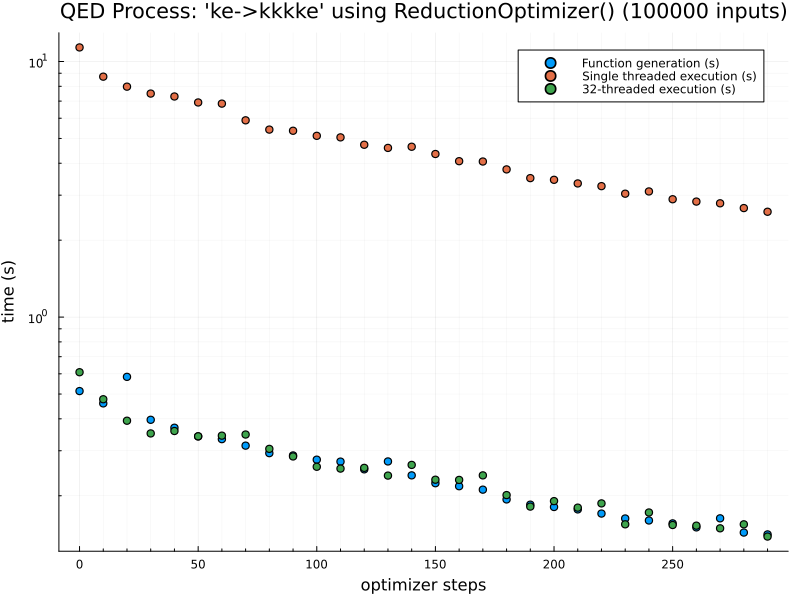

In [ ]:
# plot data
using Plots
using StatsPlots

img = @df df scatter(
    :operations, 
    [:gen_func_t, :cpu_st_t, :cpu_mt_t], 
    label=["Function generation (s)" "Single threaded execution (s)" "$(Threads.nthreads())-threaded execution (s)"], 
    title="$process using $optimizer ($(n_inputs) inputs)",
    linewidth=2,
    xlabel="optimizer steps",
    ylabel="time (s)",
    yscale=:log10,
    minorgrid=true,
    size=(800, 600),
    fmt=:pdf
)

savefig(img, "../images/$(String(process))_exec_$(n_inputs)_inputs.pdf")

img

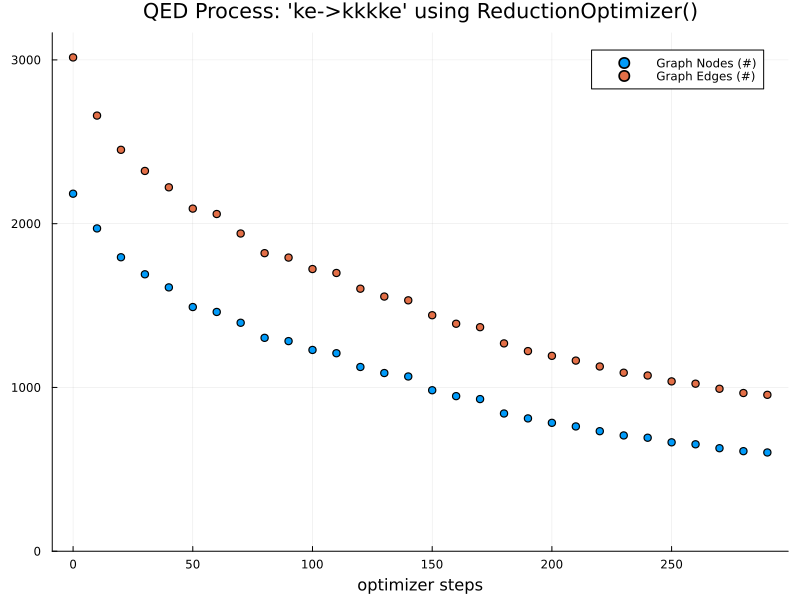

In [ ]:
img = @df df scatter(
    :operations,
    [:graph_nodes, :graph_edges],
    label=["Graph Nodes (#)" "Graph Edges (#)"],
    title="$process using $optimizer",
    linewidth=2,
    xlabel="optimizer steps",
    ylims=(0.0, 1.05 * maximum(df.graph_edges)),
    fmt=:pdf,
    size=(800, 600)
)

savefig(img, "../images/$(String(process))_graph_properties.pdf")

img